# Hand Gesture Classification using EMG

**EMG Pattern Classification**

For recording patterns, the authors (1) used a MYO Thalmic bracelet worn on a user’s forearm, and a PC with a Bluetooth receiver. The bracelet is equipped with **eight sensors** equally spaced around the forearm that simultaneously acquire myographic signals. The signals are sent through a Bluetooth interface to a PC. 


    Author: Debanjan Saha
    College: Northeastern University
    Group: Project Group 7
    Batch: Wednesday
    Course: IE 7300
    Professor: Ramin M.

This dataset contains raw EMG data for **36** subjects while they performed series of static hand gestures.The subject performs two series, each of which consists of **six (seven) basic gestures**. Each gesture was **performed for 3 seconds** with a **pause** of **3 seconds between gestures**.

**Relevant Papers**:
1. Lobov S., Krilova N., Kastalskiy I., Kazantsev V., Makarov V.A. Latent Factors Limiting the Performance of sEMG-Interfaces. Sensors. 2018;18(4):1122. doi: 10.3390/s18041122

2. Côté Allard, Ulysse & Fall, C. L. & Campeau-Lecours, Alexandre & Gosselin, Clément & Laviolette, Francois & Gosselin, Benoit. (2017). Transfer Learning for sEMG Hand Gesture Recognition Using Convolutional Neural Networks. 10.1109/SMC.2017.8122854.


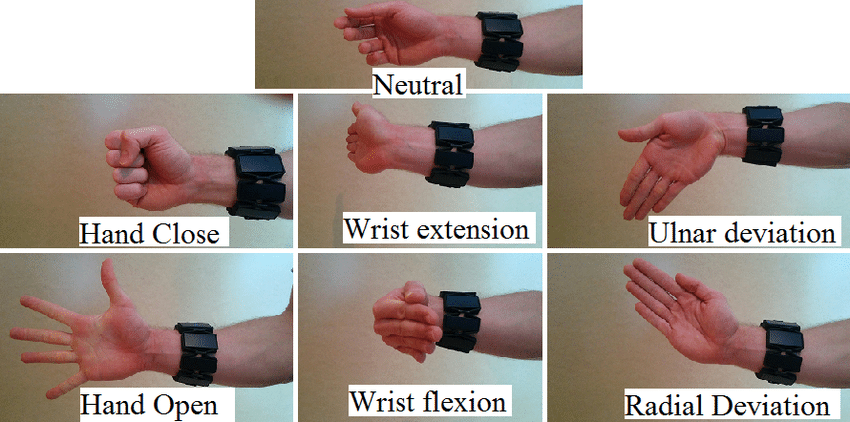

Image Source: Allard et. al (2)

## Import Libraries

In [1]:
!pip install nolds
!pip install pycatch22
!pip install torchsummary
# !pip install pyeeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 KB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.2-cp39-cp39-linux_x86_64.whl size=118685 sha256=cec359293af7f981eccf5615eb9ca0282375d9479f4ed8cca09792d93f080636
  Stored in directory: /root/.cache/pip/wheels/c0/84/da/f210e9de22c6265163dac19287b0674e040605dfc519d83ca5
Successfully built pycatch22
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import warnings
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pywt
import librosa
import nolds
# import pyeeg
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
from numpy.lib.stride_tricks import sliding_window_view
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 500)

In [3]:
import statistics
from scipy import stats
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt
import pycatch22
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

In [4]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master'
!ls -lrt

/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master
total 630232
-rw------- 1 root root      1453 Dec  7  2018 README.txt
drwx------ 2 root root      4096 Mar 23 20:40 10
drwx------ 2 root root      4096 Mar 23 20:40 09
drwx------ 2 root root      4096 Mar 23 20:40 08
drwx------ 2 root root      4096 Mar 23 20:40 07
drwx------ 2 root root      4096 Mar 23 20:40 06
drwx------ 2 root root      4096 Mar 23 20:40 05
drwx------ 2 root root      4096 Mar 23 20:40 04
drwx------ 2 root root      4096 Mar 23 20:40 03
drwx------ 2 root root      4096 Mar 23 20:40 02
drwx------ 2 root root      4096 Mar 23 20:40 01
drwx------ 2 root root      4096 Mar 23 20:40 20
drwx------ 2 root root      4096 Mar 23 20:40 19
drwx------ 2 root root      4096 Mar 23 20:40 18
drwx------ 2 root root      4096 Mar 23 20:40 17
drwx------ 2 root root      4096 Mar 23 20:40 16
drwx------ 2 root root      4096 Mar 23 20:40 15
drwx------ 2 root root      4096 Mar 23 20:40 14
drwx----

## Read Data

In [6]:
# List out all the available files in the project's environment
files_path = set()
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/'):
    for filename in filenames:
        f_path = os.path.join(dirname, filename)
        files_path.add(f_path)

In [7]:
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/README.txt')
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/all_ext_features_data.csv')
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/Segmented_Catch22_Subject1.csv')
files_path

{'/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/01/1_raw_data_13-12_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/01/2_raw_data_13-13_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/02/1_raw_data_14-19_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/02/2_raw_data_14-21_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/03/1_raw_data_09-32_11.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/03/2_raw_data_09-34_11.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/04/1_raw_data_18-02_24.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/04/2_raw_data_18-03_24.04.1

In [8]:
all_train = pd.DataFrame()
all_test = pd.DataFrame()
for id, file in enumerate(tqdm(sorted(files_path))):
    
    sub = int(file.split('/')[-2])
    data = pd.read_csv(file, sep='\t')
    subject_id = np.ones([len(data),1], dtype=np.int16)*sub
    print('\tSubject Id: \t', sub, '\tShape: ', subject_id.shape)
    # Add the subject into the data
    data['subject_id'] = subject_id
    if id%2 == 1: 
        all_train = pd.concat([all_train, data], axis=0, ignore_index=True, copy=True)
    else:
        all_test = pd.concat([all_test, data], axis=0, ignore_index=True, copy=True)

print('Total Training Records: ', all_train.shape)
print('Total Testing Records: ', all_test.shape)

  1%|▏         | 1/70 [00:00<00:28,  2.45it/s]

	Subject Id: 	 1 	Shape:  (63196, 1)


  3%|▎         | 2/70 [00:00<00:26,  2.54it/s]

	Subject Id: 	 1 	Shape:  (57974, 1)


  4%|▍         | 3/70 [00:01<00:25,  2.68it/s]

	Subject Id: 	 2 	Shape:  (72322, 1)


  6%|▌         | 4/70 [00:01<00:25,  2.62it/s]

	Subject Id: 	 2 	Shape:  (64104, 1)


  7%|▋         | 5/70 [00:01<00:24,  2.70it/s]

	Subject Id: 	 3 	Shape:  (56568, 1)


  9%|▊         | 6/70 [00:02<00:27,  2.35it/s]

	Subject Id: 	 3 	Shape:  (49217, 1)


 10%|█         | 7/70 [00:02<00:26,  2.39it/s]

	Subject Id: 	 4 	Shape:  (59107, 1)


 11%|█▏        | 8/70 [00:03<00:24,  2.50it/s]

	Subject Id: 	 4 	Shape:  (55091, 1)


 13%|█▎        | 9/70 [00:03<00:22,  2.71it/s]

	Subject Id: 	 5 	Shape:  (57118, 1)


 14%|█▍        | 10/70 [00:03<00:22,  2.69it/s]

	Subject Id: 	 5 	Shape:  (50130, 1)


 16%|█▌        | 11/70 [00:04<00:21,  2.73it/s]

	Subject Id: 	 6 	Shape:  (51078, 1)


 17%|█▋        | 12/70 [00:04<00:22,  2.63it/s]

	Subject Id: 	 6 	Shape:  (48541, 1)


 19%|█▊        | 13/70 [00:05<00:24,  2.37it/s]

	Subject Id: 	 7 	Shape:  (68697, 1)


 20%|██        | 14/70 [00:05<00:23,  2.42it/s]

	Subject Id: 	 7 	Shape:  (63943, 1)


 21%|██▏       | 15/70 [00:05<00:22,  2.42it/s]

	Subject Id: 	 8 	Shape:  (60280, 1)


 23%|██▎       | 16/70 [00:06<00:21,  2.54it/s]

	Subject Id: 	 8 	Shape:  (57668, 1)


 24%|██▍       | 17/70 [00:06<00:20,  2.58it/s]

	Subject Id: 	 9 	Shape:  (62770, 1)


 26%|██▌       | 18/70 [00:07<00:20,  2.60it/s]

	Subject Id: 	 9 	Shape:  (64877, 1)


 27%|██▋       | 19/70 [00:07<00:19,  2.57it/s]

	Subject Id: 	 10 	Shape:  (61641, 1)


 29%|██▊       | 20/70 [00:07<00:18,  2.67it/s]

	Subject Id: 	 10 	Shape:  (61448, 1)


 30%|███       | 21/70 [00:08<00:19,  2.49it/s]

	Subject Id: 	 11 	Shape:  (74681, 1)


 31%|███▏      | 22/70 [00:08<00:19,  2.50it/s]

	Subject Id: 	 11 	Shape:  (72645, 1)


 33%|███▎      | 23/70 [00:09<00:18,  2.52it/s]

	Subject Id: 	 13 	Shape:  (75676, 1)


 34%|███▍      | 24/70 [00:09<00:19,  2.35it/s]

	Subject Id: 	 13 	Shape:  (77564, 1)


 36%|███▌      | 25/70 [00:09<00:17,  2.52it/s]

	Subject Id: 	 14 	Shape:  (52821, 1)


 37%|███▋      | 26/70 [00:10<00:16,  2.59it/s]

	Subject Id: 	 14 	Shape:  (48182, 1)


 39%|███▊      | 27/70 [00:10<00:15,  2.76it/s]

	Subject Id: 	 15 	Shape:  (53553, 1)


 40%|████      | 28/70 [00:10<00:15,  2.65it/s]

	Subject Id: 	 15 	Shape:  (51843, 1)


 41%|████▏     | 29/70 [00:11<00:14,  2.86it/s]

	Subject Id: 	 16 	Shape:  (55489, 1)


 43%|████▎     | 30/70 [00:11<00:13,  2.86it/s]

	Subject Id: 	 16 	Shape:  (50012, 1)


 44%|████▍     | 31/70 [00:11<00:14,  2.73it/s]

	Subject Id: 	 17 	Shape:  (65227, 1)


 46%|████▌     | 32/70 [00:12<00:14,  2.69it/s]

	Subject Id: 	 17 	Shape:  (66858, 1)


 47%|████▋     | 33/70 [00:12<00:13,  2.75it/s]

	Subject Id: 	 18 	Shape:  (62354, 1)


 49%|████▊     | 34/70 [00:13<00:13,  2.69it/s]

	Subject Id: 	 18 	Shape:  (66958, 1)


 50%|█████     | 35/70 [00:13<00:12,  2.76it/s]

	Subject Id: 	 19 	Shape:  (58818, 1)


 51%|█████▏    | 36/70 [00:13<00:11,  2.87it/s]

	Subject Id: 	 19 	Shape:  (51088, 1)


 53%|█████▎    | 37/70 [00:14<00:11,  2.91it/s]

	Subject Id: 	 20 	Shape:  (65349, 1)


 54%|█████▍    | 38/70 [00:14<00:11,  2.70it/s]

	Subject Id: 	 20 	Shape:  (62504, 1)


 56%|█████▌    | 39/70 [00:14<00:12,  2.49it/s]

	Subject Id: 	 21 	Shape:  (62365, 1)


 57%|█████▋    | 40/70 [00:15<00:11,  2.68it/s]

	Subject Id: 	 21 	Shape:  (56882, 1)


 59%|█████▊    | 41/70 [00:15<00:10,  2.71it/s]

	Subject Id: 	 22 	Shape:  (61788, 1)


 60%|██████    | 42/70 [00:16<00:10,  2.66it/s]

	Subject Id: 	 22 	Shape:  (57841, 1)


 61%|██████▏   | 43/70 [00:16<00:09,  2.81it/s]

	Subject Id: 	 23 	Shape:  (60135, 1)


 63%|██████▎   | 44/70 [00:16<00:10,  2.45it/s]

	Subject Id: 	 23 	Shape:  (55484, 1)


 64%|██████▍   | 45/70 [00:17<00:10,  2.50it/s]

	Subject Id: 	 24 	Shape:  (61968, 1)


 66%|██████▌   | 46/70 [00:17<00:10,  2.26it/s]

	Subject Id: 	 24 	Shape:  (54972, 1)


 67%|██████▋   | 47/70 [00:18<00:09,  2.35it/s]

	Subject Id: 	 25 	Shape:  (62681, 1)


 69%|██████▊   | 48/70 [00:18<00:08,  2.51it/s]

	Subject Id: 	 25 	Shape:  (54066, 1)


 70%|███████   | 49/70 [00:19<00:09,  2.23it/s]

	Subject Id: 	 26 	Shape:  (56151, 1)


 71%|███████▏  | 50/70 [00:19<00:08,  2.29it/s]

	Subject Id: 	 26 	Shape:  (50003, 1)


 73%|███████▎  | 51/70 [00:19<00:08,  2.31it/s]

	Subject Id: 	 27 	Shape:  (56688, 1)


 74%|███████▍  | 52/70 [00:20<00:07,  2.37it/s]

	Subject Id: 	 27 	Shape:  (50111, 1)


 76%|███████▌  | 53/70 [00:20<00:06,  2.54it/s]

	Subject Id: 	 28 	Shape:  (50513, 1)


 77%|███████▋  | 54/70 [00:21<00:06,  2.47it/s]

	Subject Id: 	 28 	Shape:  (47253, 1)


 79%|███████▊  | 55/70 [00:21<00:07,  2.14it/s]

	Subject Id: 	 29 	Shape:  (53904, 1)


 80%|████████  | 56/70 [00:22<00:06,  2.20it/s]

	Subject Id: 	 29 	Shape:  (52083, 1)


 81%|████████▏ | 57/70 [00:22<00:06,  1.92it/s]

	Subject Id: 	 30 	Shape:  (77878, 1)


 83%|████████▎ | 58/70 [00:23<00:06,  1.80it/s]

	Subject Id: 	 30 	Shape:  (70683, 1)


 84%|████████▍ | 59/70 [00:23<00:05,  2.06it/s]

	Subject Id: 	 31 	Shape:  (44927, 1)


 86%|████████▌ | 60/70 [00:24<00:05,  1.92it/s]

	Subject Id: 	 31 	Shape:  (46096, 1)


 87%|████████▋ | 61/70 [00:24<00:04,  1.91it/s]

	Subject Id: 	 32 	Shape:  (62719, 1)


 89%|████████▊ | 62/70 [00:25<00:03,  2.12it/s]

	Subject Id: 	 32 	Shape:  (60211, 1)


 90%|█████████ | 63/70 [00:25<00:02,  2.35it/s]

	Subject Id: 	 33 	Shape:  (59017, 1)


 91%|█████████▏| 64/70 [00:25<00:02,  2.35it/s]

	Subject Id: 	 33 	Shape:  (53088, 1)


 93%|█████████▎| 65/70 [00:26<00:02,  2.33it/s]

	Subject Id: 	 34 	Shape:  (79765, 1)


 94%|█████████▍| 66/70 [00:26<00:01,  2.40it/s]

	Subject Id: 	 34 	Shape:  (51438, 1)


 96%|█████████▌| 67/70 [00:27<00:01,  2.61it/s]

	Subject Id: 	 35 	Shape:  (50417, 1)


 97%|█████████▋| 68/70 [00:27<00:00,  2.76it/s]

	Subject Id: 	 35 	Shape:  (49084, 1)


 99%|█████████▊| 69/70 [00:27<00:00,  2.46it/s]

	Subject Id: 	 36 	Shape:  (52390, 1)


100%|██████████| 70/70 [00:28<00:00,  2.48it/s]

	Subject Id: 	 36 	Shape:  (49364, 1)
Total Training Records:  (1979306, 11)
Total Testing Records:  (2130051, 11)


In [9]:
all_train.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,2,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,1
1,6,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,1
2,7,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0,1
3,8,-0.00003,-0.00005,-0.00008,-0.00004,-0.00003,0.00000,-0.00002,0.00000,0,1
4,9,-0.00003,-0.00001,0.00000,0.00001,-0.00001,0.00000,0.00000,-0.00002,0,1


In [10]:
all_test.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1


## Data Exploration
The data has the target variable `class` which can have values from 1 to 7, whereas, the data `class = 0` is unmarked data, which we have to infer with the model which has learned the gestures.

Here are the following gesture descriptions:
0. unmarked data,
1. hand at rest, 
2. hand clenched in a fist, 
3. wrist flexion,
4. wrist extension,
5. radial deviations,
6. ulnar deviations,
7. extended palm (the gesture was not performed by all subjects).

The data contains gesture class marked as 0 as an unsupervised classification problem. So, we shall be using the labeled data for our analysis.
So we can split the data into training and testing sets based on this `class` column, where all data for class = 0 will be our holdout data, and the labeled data will be for classes = 1,2,3,4,5,6, and 7.



### Channel-wise Distribution 

In [11]:
# def plot_all_channels(data, idx_start, idx_end):
#     fig = make_subplots(rows=len(data.columns), cols=1, shared_xaxes=True)
#     for i, col in enumerate(data.columns):
#         fig.add_trace(go.Scatter(x=data.index[idx_start:idx_end], y=data[col][idx_start:idx_end], name=col), row=i+1, col=1)

#     fig.update_layout(height=800, width=1200, title_text="All Channels of EMG Data Samples")
#     fig.show()

# sub_df = all_train[all_train['subject_id'] == 1].iloc[:,1:-1]
# plot_all_channels(sub_df, 0, len(sub_df))


### Frequency Spectrum

In [12]:
# SAMPLING_FREQ = 1000

# def plot_freq_domain(signal, frequencies, fig, row, col, plot_title):
#     '''Plots the frequency spectrum of a given signal'''
#     frequency_spectrum = rfft(signal) # rfft as input is real numbers
#     fig.add_trace(go.Scatter(x=frequencies, y=np.abs(frequency_spectrum),
#                   mode='lines', name=plot_title), row=row, col=col)

# def get_filter(filter_type, cutoff):
#     # Compute Nyquist frequency
#     nyquist_freq = SAMPLING_FREQ/2 # Hz
#     # Convert cutoff frequencies to fractions of Nyquist frequency
#     cutoff_freqs_frac = [x/nyquist_freq for x in cutoff]
#     # Compute filter coefficients using Butterworth filter design
#     b, a = butter(FILTER_ORDER, cutoff_freqs_frac, btype=filter_type, analog=False)
#     # Return filter coefficients
#     return b, a

In [13]:
# # Set the filter order to 4
# FILTER_ORDER = 4

# # Define a bandpass filter with cutoff frequencies of 20 Hz and 450 Hz
# cutoff_freqs = [20, 450] # Hz
# b_bandpass, a_bandpass = get_filter('bandpass', cutoff_freqs)

# # Define a bandstop filter with cutoff frequencies of 45 Hz and 55 Hz
# cutoff_freqs = [45, 55]
# b_bandstop, a_bandstop = get_filter('bandstop', cutoff_freqs)


In [14]:
# fig = make_subplots(rows=7, cols=2, 
#                     subplot_titles=[f'{spec_type} Spectrum of channel{i}' for i in range(1, 8) for spec_type in ['Original', 'Filtered']],
#                     vertical_spacing=0.03, horizontal_spacing=0.05)

# for i in range(1, 8):
#     channel_name = f'channel{i}'
#     unfiltered_signal = sub_df[channel_name].to_numpy()
#     num_samples = len(unfiltered_signal)
#     frequencies = rfftfreq(num_samples, 1/SAMPLING_FREQ) # get frequencies
#     plot_freq_domain(unfiltered_signal, frequencies, fig, i, 1, f'Original Spectrum of {channel_name}')

#     filtered_signal_1 = filtfilt(b_bandpass, a_bandpass, unfiltered_signal, padlen=0, axis=0)
#     filtered_signal = filtfilt(b_bandstop, a_bandstop, filtered_signal_1, padlen=0, axis=0)
#     plot_freq_domain(filtered_signal, frequencies, fig, i, 2, f'Filtered Spectrum of {channel_name}')

# fig.update_layout(height=3000, width=1200, title='Frequency Spectrum of EMG Signals')
# fig.update_xaxes(title_text='Hz')
# fig.update_yaxes(title_text='Amplitude', row=1, col=1)
# fig.update_yaxes(title_text='Amplitude', row=1, col=2)
# fig.show()


In [15]:
# def plot_class_instances(y):
#     targets = y.unique()
#     instances = y.value_counts().to_list()
#     color_palette = sns.color_palette("bright", len(targets))
#     fig, ax = plt.subplots(figsize=(10, 6))
#     sns.barplot(x=targets, y=instances, palette=color_palette, ax=ax)
#     ax.set(xlabel='Class', ylabel='Number of Instances')
#     sns.despine()

#     for i, label in enumerate(instances):
#         ax.annotate(label, (i, instances[i]), ha='center', va='bottom', fontsize=10)

#     plt.show()

# # plot class instances with data labelled 0 removed
# plot_class_instances(all_train[all_train['class'] != 0]['class'])


## Data Preprocessing

In [16]:
# Check for missing values
print(all_train.isnull().sum())

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         0
subject_id    0
dtype: int64


In [17]:
print(all_test.isnull().sum())

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         1
subject_id    0
dtype: int64


In [18]:
# Fill missing value with 0
all_test = all_test.fillna(0)

In [19]:
# Check for missing values
print(all_test.isnull().sum())

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         0
subject_id    0
dtype: int64


In [20]:
# Check for outliers
print(all_train.describe())

               time      channel1      channel2      channel3      channel4  \
count  1.979306e+06  1.979306e+06  1.979306e+06  1.979306e+06  1.979306e+06   
mean   2.990299e+04 -8.164574e-06 -9.507843e-06 -9.604371e-06 -9.696227e-06   
std    1.794606e+04  1.651789e-04  1.190196e-04  1.213319e-04  2.275688e-04   
min    1.000000e+00 -1.280000e-03 -1.280000e-03 -1.280000e-03 -1.280000e-03   
25%    1.468400e+04 -3.000000e-05 -4.000000e-05 -4.000000e-05 -6.000000e-05   
50%    2.933250e+04 -1.000000e-05 -1.000000e-05 -1.000000e-05 -1.000000e-05   
75%    4.399400e+04  2.000000e-05  2.000000e-05  3.000000e-05  4.000000e-05   
max    8.135700e+04  1.270000e-03  1.270000e-03  1.270000e-03  1.270000e-03   

           channel5      channel6      channel7      channel8         class  \
count  1.979306e+06  1.979306e+06  1.979306e+06  1.979306e+06  1.979306e+06   
mean  -1.638671e-05 -1.065114e-05 -9.482879e-06 -1.014557e-05  1.318564e+00   
std    2.768523e-04  2.151942e-04  1.536401e-04  1.

In [21]:
all_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979306 entries, 0 to 1979305
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   time        int64  
 1   channel1    float64
 2   channel2    float64
 3   channel3    float64
 4   channel4    float64
 5   channel5    float64
 6   channel6    float64
 7   channel7    float64
 8   channel8    float64
 9   class       int64  
 10  subject_id  int16  
dtypes: float64(8), int16(1), int64(2)
memory usage: 154.8 MB


### Holdout Data

In [22]:
holdout_data_train = all_train.loc[all_train['class'] == 0]
holdout_data_test = all_test.loc[all_test['class'] == 0]
holdout_data = pd.concat([holdout_data_train, holdout_data_test], axis=0)
holdout_data = holdout_data.reset_index(drop=True)

In [23]:
holdout_data

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,2,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0.0,1
1,6,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0.0,1
2,7,-0.00001,-0.00004,-0.00002,-0.00002,-0.00001,-0.00001,0.00001,-0.00003,0.0,1
3,8,-0.00003,-0.00005,-0.00008,-0.00004,-0.00003,0.00000,-0.00002,0.00000,0.0,1
4,9,-0.00003,-0.00001,0.00000,0.00001,-0.00001,0.00000,0.00000,-0.00002,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2640097,54832,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36
2640098,54833,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36
2640099,54834,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36
2640100,54835,-0.00004,-0.00006,-0.00008,-0.00014,-0.00002,0.00000,-0.00002,-0.00001,0.0,36


#### Plot Data

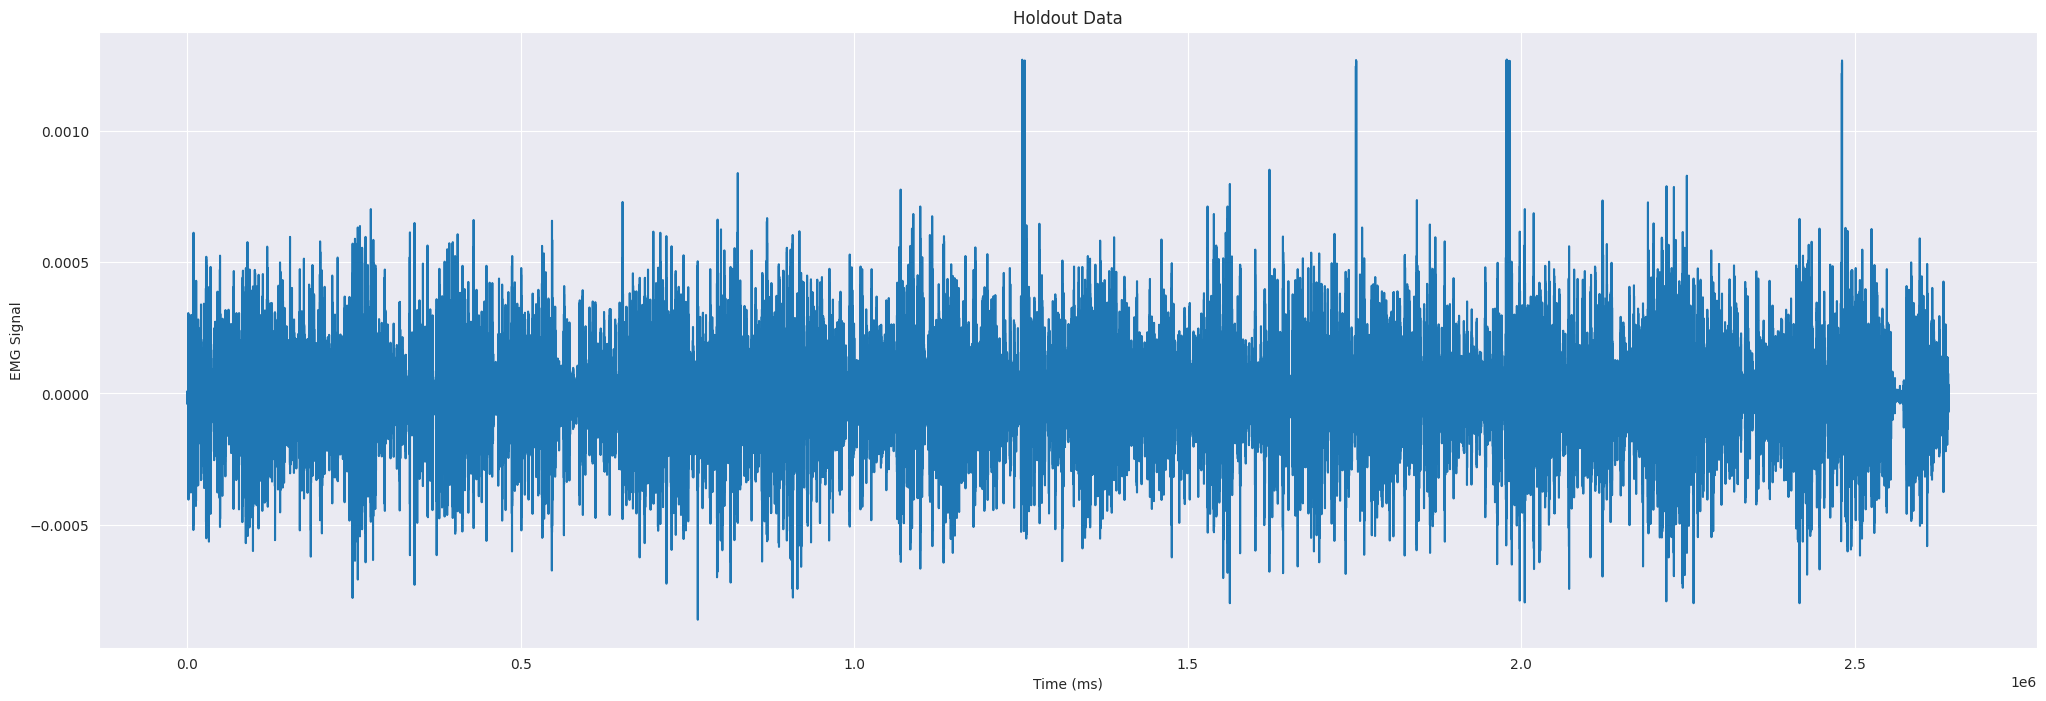

In [24]:
# Plot Holdout data
plt.figure(figsize=(25,8))
plt.plot(holdout_data[holdout_data['class'] == 0].iloc[:, 1:8].mean(axis=1))

# Add a legend and set the title and axis labels
plt.title('Holdout Data')
plt.xlabel('Time (ms)')
plt.ylabel('EMG Signal')
# Show the plot
plt.show()

### Train Test Split

The overall data is collected for 36 subjects, who perform a series of gestures with an interval of 3 seconds. These subjects perform these activities twice. For the sake of consistency, we will consider the first trial as our training data and the second trial as our test data. Also, the data contains unmarked gestures (class = 0), which we have separated out as holdout.

In [25]:
labeled_train = all_train.loc[all_train['class'] != 0]
labeled_train = labeled_train.reset_index(drop=True)

labeled_test = all_test.loc[all_test['class'] != 0]
labeled_test = labeled_test.reset_index(drop=True)

In [73]:
print("Labeled Train Shape: ", labeled_train.shape)
labeled_train

Labeled Train Shape:  (732932, 11)


,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,880,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
1,881,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
2,882,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
3,883,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
4,884,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
...,...,...,...,...,...,...,...,...,...,...,...
732927,50226,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6,36
732928,50227,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6,36
732929,50228,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6,36
732930,50229,0.00014,0.00003,-0.00001,0.00001,-0.00012,0.00006,-0.00007,-0.00013,6,36


In [27]:
labeled_test

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,2400,-0.00001,0.00000,-0.00001,0.00000,0.00000,-0.00001,-0.00001,0.00001,1.0,1
1,2401,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
2,2402,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
3,2403,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
4,2404,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
736318,53577,0.00001,0.00000,-0.00002,0.00002,-0.00010,0.00004,-0.00003,-0.00004,6.0,36
736319,53578,0.00001,0.00000,-0.00002,0.00002,-0.00010,0.00004,-0.00003,-0.00004,6.0,36
736320,53579,0.00005,0.00002,0.00000,0.00000,-0.00005,-0.00005,-0.00004,-0.00001,6.0,36
736321,53580,0.00005,0.00002,0.00000,0.00000,-0.00005,-0.00005,-0.00004,-0.00001,6.0,36


#### Plot Data

In [28]:
def plot_labeled_data(df, str_title):
    # Create a dictionary of gestures and their corresponding colors
    gesture_colors = {1: 'blue', 2: 'orange', 3: 'green', 4: 'red', 5: 'purple', 6: 'brown', 7: 'pink'}

    plt.figure(figsize=(25,8))
    # Iterate through each gesture and plot it with a different color
    for gesture in gesture_colors:
        gesture_data = df[df['class'] == gesture].iloc[:, 1:8].mean(axis=1)
        plt.plot(gesture_data, color=gesture_colors[gesture], label=f'Gesture {gesture}')

    # Add a legend and set the title and axis labels
    plt.title(str_title)
    plt.xlabel('Time (ms)')
    plt.ylabel('EMG Signal')
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()

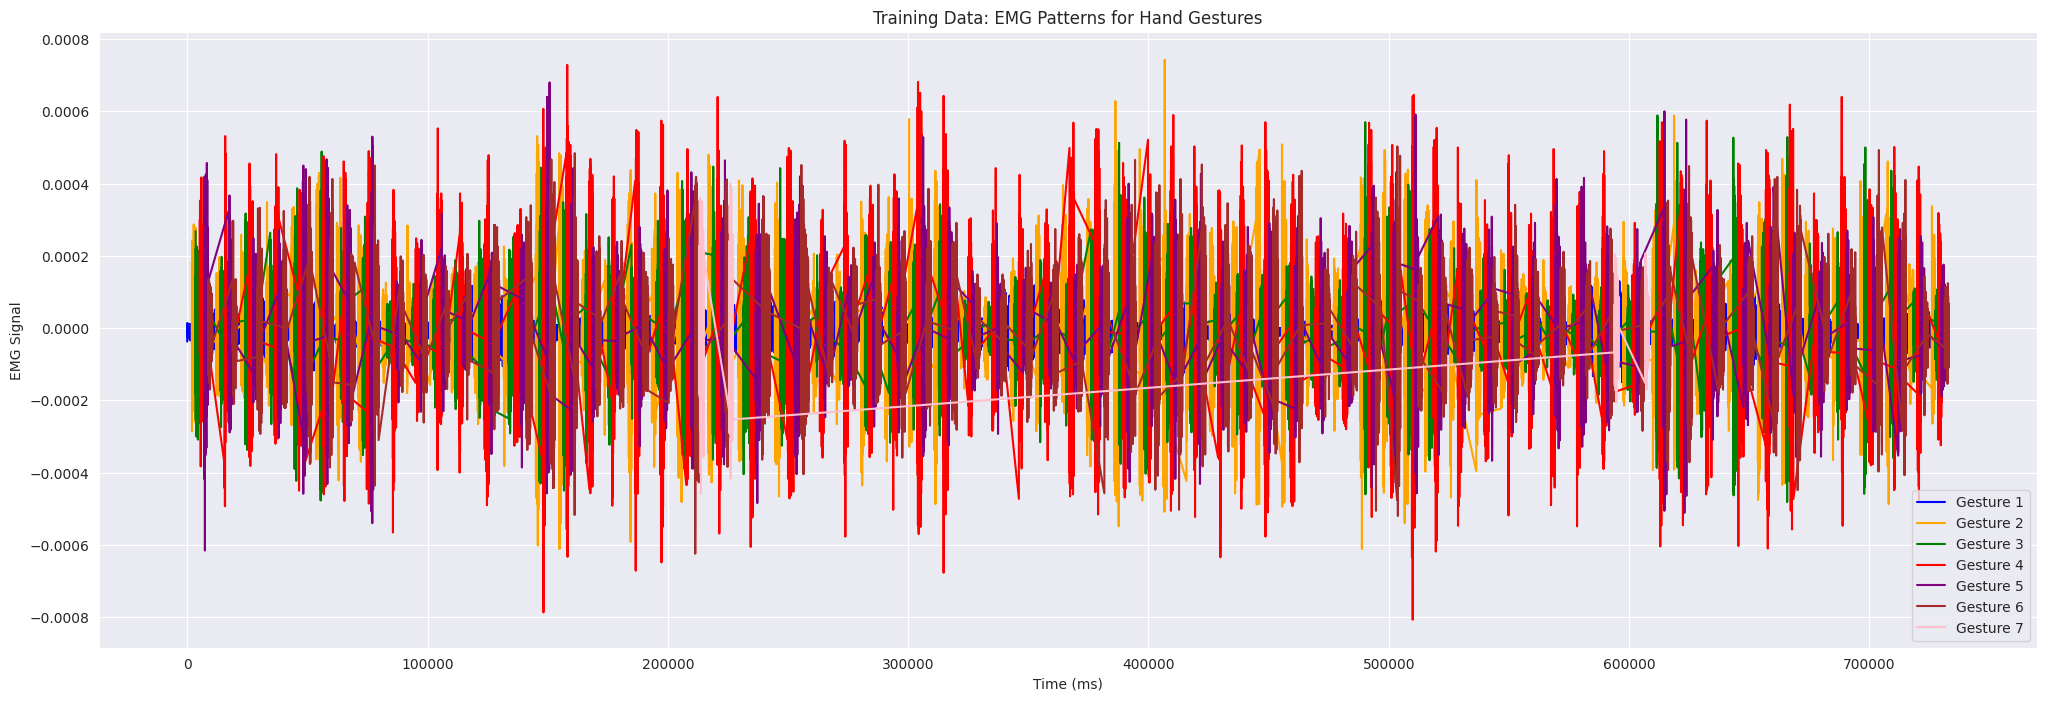

In [29]:
plot_labeled_data(labeled_train, 'Training Data: EMG Patterns for Hand Gestures')

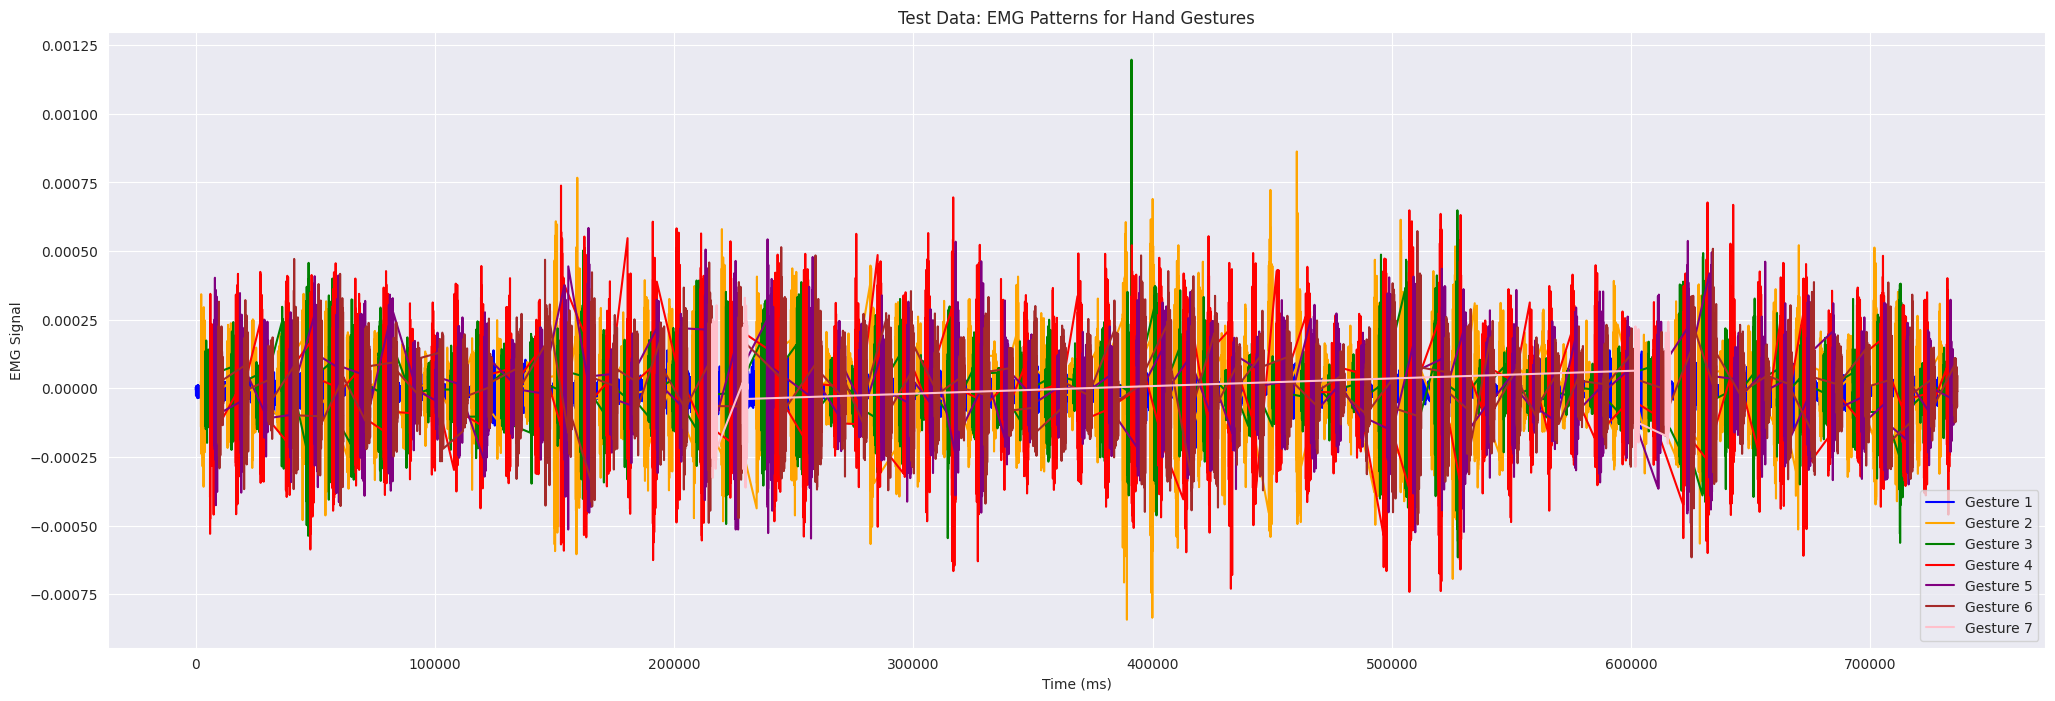

In [30]:
plot_labeled_data(labeled_test, 'Test Data: EMG Patterns for Hand Gestures')

In [31]:
print('Train Classes: ', labeled_train['class'].unique())
print('Test Classes: ', labeled_test['class'].unique())

Train Classes:  [1 2 3 4 5 6 7]
Test Classes:  [1. 2. 3. 4. 5. 6. 7.]


In [32]:
labeled_test.isna().sum()

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         0
subject_id    0
dtype: int64

## Feature Engineering

Now, we have separated the train and test sets, so we will perform `catch22` feature engineering for extracting features that capture the overall pattern of activity across all the sensors. So, want to apply `catch22` to the entire data for each row.

In [33]:
def catch22_features(df, signal_interval=1024):
    catch22_list = []
    # iterate over each subject in the data
    for subject_id in df['subject_id'].unique():
        # iterate over each channel in the data
        for channel in range(1, 9):
            sub_df = df.loc[df['subject_id']==subject_id, f'channel{channel}']
            # split the data into intervals of length 1024
            intervals = np.array_split(sub_df, len(sub_df)//signal_interval)
            y_segments = np.array_split(df.loc[df['subject_id']==subject_id, 'class'], len(sub_df)//signal_interval)
            # for each signal interval
            for int_idx, interval in enumerate(intervals):
                # apply catch22 on the interval and compute the mean of all the features
                features_interval = pycatch22.catch22_all(interval)
                # compute more statistical features for the data of each channel
                interval_stats = {}
                class_mode = statistics.mode(y_segments[int_idx])
                interval_stats['class_mode'] = class_mode
                interval_stats['subject_id'] = subject_id
                interval_stats['channel'] = channel
                interval_stats['interval'] = int_idx
                interval_stats['mean'] = np.mean(interval)
                interval_stats['std'] = np.std(interval)
                interval_stats['var'] = np.var(interval)
                interval_stats['min'] = np.min(interval)
                interval_stats['max'] = np.max(interval)    
                interval_stats['ptp'] = np.ptp(interval)    
                interval_stats['rms'] = np.sqrt(np.mean(interval**2))    
                interval_stats['skew'] = stats.skew(interval)    
                interval_stats['kurtosis'] = stats.kurtosis(interval)    
                # map feature names to feature values for each signal interval
                features_mean = {feature_name: feature_value for feature_name, feature_value in zip(features_interval['names'], features_interval['values'])}
                interval_dict = {**interval_stats, **features_mean}
                catch22_list.append(interval_dict)

    catch22_df = pd.DataFrame(catch22_list)
    return catch22_df

In [34]:
catch22_train = catch22_features(labeled_train)
catch22_train

,class_mode,subject_id,channel,interval,mean,std,var,min,max,ptp,rms,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1,1,1,0,-0.000008,0.000017,2.852101e-10,-0.00004,0.00004,0.00008,0.000018,0.811886,1.272265,-0.502923,-0.266185,9.917299,29,0.879749,-0.035493,0.083658,33.0,0.035601,62,0.195664,16.0,0.055556,-0.046647,-0.077745,0.923235,3.0,1.185875,0.520833,0.395833,0.101243,0.470717
1,1,1,1,1,-0.000015,0.000072,5.208689e-09,-0.00057,0.00051,0.00108,0.000074,-1.813818,15.443139,-0.213593,0.534264,8.878072,21,0.256094,-0.190795,0.080739,99.0,0.013796,70,0.066801,15.0,0.058824,0.805637,0.886297,0.827459,3.0,1.238810,0.375000,0.208333,0.116583,0.576409
2,2,1,1,2,-0.000003,0.000264,6.970525e-08,-0.00066,0.00062,0.00128,0.000264,-0.088388,-0.308775,-0.064274,0.178017,11.082004,24,0.927665,0.029758,0.092412,66.0,0.012008,126,0.194056,19.0,0.047619,0.294947,-0.178814,0.908236,3.0,1.395526,0.500000,0.354167,0.104311,0.489386
3,3,1,1,3,-0.000013,0.000231,5.354323e-08,-0.00081,0.00112,0.00193,0.000232,0.255314,4.094293,0.725862,0.309027,9.734215,24,0.535289,-0.007236,0.090467,81.0,0.001600,71,0.162571,18.0,0.052632,-0.119534,-0.689018,0.891323,3.0,1.383954,0.562500,0.645833,0.101243,0.525007
4,3,1,1,4,0.000011,0.000229,5.229659e-08,-0.00087,0.00061,0.00148,0.000229,-0.516455,3.487857,0.676899,0.353466,8.563549,21,0.711573,-0.077124,0.103213,52.0,0.008057,69,0.197893,14.0,0.062500,-0.321498,-0.358949,0.914520,3.0,1.395433,0.479167,0.416667,0.113515,0.493081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,3,36,8,12,-0.000010,0.000067,4.462154e-09,-0.00020,0.00015,0.00035,0.000067,-0.471653,0.738986,-0.231182,0.554378,9.162435,30,0.784625,0.033045,0.099712,38.0,0.006669,122,0.221273,17.0,0.055556,-0.086207,-0.407088,0.898303,3.0,1.390511,0.604167,0.479167,0.110447,0.507381
5564,4,36,8,13,-0.000008,0.000046,2.120054e-09,-0.00016,0.00015,0.00031,0.000047,0.483267,1.226203,0.058428,-0.278044,9.677923,22,0.779792,0.065751,0.093960,51.0,0.003125,82,0.166129,21.0,0.038462,0.155172,0.048851,0.868697,3.0,1.393197,0.520833,0.562500,0.104311,0.538410
5565,5,36,8,14,-0.000008,0.000032,1.023969e-09,-0.00009,0.00010,0.00019,0.000033,0.228893,0.680643,0.419465,0.122728,7.804646,22,0.761313,-0.005493,0.108341,58.0,0.003945,36,0.167986,15.0,0.062500,-0.491379,-0.283525,0.886062,3.0,1.434484,0.416667,0.645833,0.153398,0.547807
5566,5,36,8,15,-0.000004,0.000057,3.254205e-09,-0.00028,0.00014,0.00042,0.000057,-0.540673,2.595853,0.320656,-0.047294,7.277011,17,0.617111,0.172848,0.099712,56.0,0.007292,60,0.128639,16.0,0.038462,0.525862,0.087165,0.861937,4.0,1.323310,0.520833,0.395833,0.116583,0.599501


In [35]:
catch22_test = catch22_features(labeled_test)
catch22_test

,class_mode,subject_id,channel,interval,mean,std,var,min,max,ptp,rms,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1.0,1,1,0,-0.000010,0.000012,1.416181e-10,-0.00004,0.00002,0.00006,0.000016,-0.203058,-0.545527,0.018504,0.270477,10.569761,46,0.942008,-0.081804,0.077661,68.0,0.004155,156,0.158986,25.0,0.037037,-0.005747,0.017241,0.914081,3.0,1.079347,0.500000,0.458333,0.085903,0.477245
1,1.0,1,1,1,-0.000009,0.000013,1.667070e-10,-0.00004,0.00002,0.00006,0.000016,-0.418770,-0.146674,-0.074151,0.158089,6.797859,16,0.899385,0.002669,0.084372,38.0,0.023244,25,0.166613,14.0,0.066667,-0.109195,0.560345,0.881859,3.0,1.185854,0.395833,0.333333,0.162602,0.577558
2,2.0,1,1,2,-0.000028,0.000248,6.167627e-08,-0.00111,0.00095,0.00206,0.000250,-0.876967,3.203998,-0.207673,0.206871,8.396841,23,0.609232,-0.013999,0.092042,73.0,0.003575,70,0.129834,18.0,0.050000,-0.252874,-0.812261,0.843965,3.0,1.383207,0.458333,0.416667,0.122718,0.596065
3,2.0,1,1,3,-0.000012,0.000244,5.944230e-08,-0.00064,0.00085,0.00149,0.000244,-0.118534,0.503527,0.478682,-0.437584,12.670202,24,0.806676,0.010292,0.087248,70.0,0.010582,31,0.163999,23.0,0.020833,-0.637931,-0.828544,0.902969,3.0,1.350090,0.375000,0.708333,0.079767,0.492917
4,3.0,1,1,4,-0.000017,0.000169,2.849122e-08,-0.00053,0.00036,0.00089,0.000170,-0.004600,-0.044157,0.651497,0.387987,10.409305,22,0.886702,-0.060302,0.084372,54.0,0.003658,105,0.163751,18.0,0.052632,-0.137931,0.200192,0.907584,3.0,1.334055,0.416667,0.458333,0.107379,0.501547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,3.0,36,8,13,-0.000007,0.000088,7.658684e-09,-0.00030,0.00022,0.00052,0.000088,-0.808155,1.066849,-0.379963,-0.083012,8.892756,22,0.689086,0.023114,0.107422,43.0,0.002848,78,0.206132,15.0,0.062500,0.031220,-0.013659,0.886854,3.0,1.409218,0.520833,0.437500,0.128854,0.533017
5612,4.0,36,8,14,-0.000010,0.000045,2.000957e-09,-0.00013,0.00012,0.00025,0.000046,-0.263410,-0.217338,0.108670,0.387976,6.643951,16,0.695987,-0.113564,0.100586,72.0,0.005942,36,0.151254,12.0,0.071429,0.002927,-0.094634,0.858080,3.0,1.418443,0.395833,0.395833,0.165670,0.601794
5613,5.0,36,8,15,-0.000012,0.000034,1.166030e-09,-0.00011,0.00009,0.00020,0.000036,-0.104150,1.536707,0.048547,0.341254,7.242392,22,0.688060,-0.176822,0.099609,66.0,0.009083,76,0.136931,14.0,0.066667,-0.363902,-0.471220,0.877859,3.0,1.376530,0.458333,0.520833,0.147262,0.569702
5614,5.0,36,8,16,-0.000011,0.000072,5.155559e-09,-0.00028,0.00021,0.00049,0.000073,-1.014367,4.668931,-0.329810,0.011238,7.202949,21,0.606460,0.009928,0.114258,60.0,0.004691,57,0.137026,12.0,0.071429,0.652683,0.845854,0.875835,3.0,1.430325,0.500000,0.375000,0.116583,0.567430


In [36]:
X_train = catch22_train.drop('class_mode', axis=1)
y_train = catch22_train['class_mode']

X_test = catch22_test.drop('class_mode', axis=1)
y_test = catch22_test['class_mode']


In [37]:
print('DATA SPLITS \n1. Train: {} \n2. Test: {}'.format(X_train.shape, X_test.shape))

DATA SPLITS 
1. Train: (5568, 34) 
2. Test: (5616, 34)


In [38]:
X_train.head()

,subject_id,channel,interval,mean,std,var,min,max,ptp,rms,skew,kurtosis,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,CO_Embed2_Dist_tau_d_expfit_meandiff,IN_AutoMutualInfoStats_40_gaussian_fmmi,FC_LocalSimple_mean1_tauresrat,DN_OutlierInclude_p_001_mdrmd,DN_OutlierInclude_n_001_mdrmd,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr
0,1,1,0,-0.000008,0.000017,2.852101e-10,-0.00004,0.00004,0.00008,0.000018,0.811886,1.272265,-0.502923,-0.266185,9.917299,29,0.879749,-0.035493,0.083658,33.0,0.035601,62,0.195664,16.0,0.055556,-0.046647,-0.077745,0.923235,3.0,1.185875,0.520833,0.395833,0.101243,0.470717
1,1,1,1,-0.000015,0.000072,5.208689e-09,-0.00057,0.00051,0.00108,0.000074,-1.813818,15.443139,-0.213593,0.534264,8.878072,21,0.256094,-0.190795,0.080739,99.0,0.013796,70,0.066801,15.0,0.058824,0.805637,0.886297,0.827459,3.0,1.238810,0.375000,0.208333,0.116583,0.576409
2,1,1,2,-0.000003,0.000264,6.970525e-08,-0.00066,0.00062,0.00128,0.000264,-0.088388,-0.308775,-0.064274,0.178017,11.082004,24,0.927665,0.029758,0.092412,66.0,0.012008,126,0.194056,19.0,0.047619,0.294947,-0.178814,0.908236,3.0,1.395526,0.500000,0.354167,0.104311,0.489386
3,1,1,3,-0.000013,0.000231,5.354323e-08,-0.00081,0.00112,0.00193,0.000232,0.255314,4.094293,0.725862,0.309027,9.734215,24,0.535289,-0.007236,0.090467,81.0,0.001600,71,0.162571,18.0,0.052632,-0.119534,-0.689018,0.891323,3.0,1.383954,0.562500,0.645833,0.101243,0.525007
4,1,1,4,0.000011,0.000229,5.229659e-08,-0.00087,0.00061,0.00148,0.000229,-0.516455,3.487857,0.676899,0.353466,8.563549,21,0.711573,-0.077124,0.103213,52.0,0.008057,69,0.197893,14.0,0.062500,-0.321498,-0.358949,0.914520,3.0,1.395433,0.479167,0.416667,0.113515,0.493081


In [39]:
# from sklearn.svm import SVC
# clf = SVC(kernel='linear')
# svm_model = clf.fit(X_train.values,y_train.values)

In [40]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier()
# rf_model = clf.fit(X_train.values,y_train.values)

In [41]:
# from sklearn.ensemble import GradientBoostingClassifier
# clf = GradientBoostingClassifier()
# gbr_model = clf.fit(X_train.values,y_train.values)

In [42]:
# def getAccuracy(pred,actual):
#     correctClassifications = 0
#     for i in range(len(pred)):
#         if pred[i] == actual[i]:
#             correctClassifications += 1
#     return (correctClassifications/len(pred)) * 100

# def model_predict(model):
#     prediction_train = model.predict(X_train.values)
#     prediction_test = model.predict(X_test.values)
#     print("Train Accuracy: ", getAccuracy(prediction_train,y_train.values))
#     print("Test Accuracy: ", getAccuracy(prediction_test,y_test.values))

In [43]:
# prediction_train = svm_model.predict(X_train.values)
# prediction_test = svm_model.predict(X_test.values)

In [44]:
# getAccuracy(prediction_train,y_train.values)

In [45]:
# getAccuracy(prediction_test,y_test.values)

In [46]:
# model_predict(rf_model)

In [47]:
# model_predict(gbr_model)

In [48]:
# !pip install lazypredict

In [49]:
# from lazypredict.Supervised import LazyClassifier

In [50]:
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# print(models)

In [51]:
# Model                                                                          
# LGBMClassifier                     0.65               0.62    None      0.65   
# BaggingClassifier                  0.61               0.57    None      0.61   
# DecisionTreeClassifier             0.55               0.52    None      0.55   
# RandomForestClassifier             0.58               0.50    None      0.58   
# ExtraTreesClassifier               0.57               0.50    None      0.57   
# AdaBoostClassifier                 0.39               0.34    None      0.38   
# SVC                                0.37               0.32    None      0.36   
# ExtraTreeClassifier                0.35               0.31    None      0.35   
# NearestCentroid                    0.31               0.31    None      0.31   
# LogisticRegression                 0.35               0.30    None      0.33   
# CalibratedClassifierCV             0.35               0.30    None      0.33   
# LinearSVC                          0.35               0.30    None      0.31   
# RidgeClassifierCV                  0.35               0.30    None      0.30   
# RidgeClassifier                    0.35               0.30    None      0.30   
# LinearDiscriminantAnalysis         0.34               0.29    None      0.33   
# GaussianNB                         0.34               0.29    None      0.32   
# SGDClassifier                      0.31               0.27    None      0.30   
# KNeighborsClassifier               0.32               0.27    None      0.31   
# QuadraticDiscriminantAnalysis      0.31               0.27    None      0.31   
# PassiveAggressiveClassifier        0.31               0.26    None      0.28   
# Perceptron                         0.30               0.26    None      0.29   
# LabelSpreading                     0.28               0.24    None      0.28   
# LabelPropagation                   0.28               0.24    None      0.28   
# BernoulliNB                        0.28               0.24    None      0.24   
# DummyClassifier                    0.17               0.14    None      0.05   

In [52]:
# catch22_df.to_csv('Segmented_Catch22_All.csv', index=False)

In [53]:
# anova = catch22_df.groupby('class_mode').apply(lambda x: pd.Series(dict(zip(x.columns[5:], [stats.f_oneway(x[x['class_mode']==c][f], x[x['class_mode']!=c][f])[0] for f in x.columns[5:]])))).reset_index()
# anova = anova.melt(id_vars=['class_mode'], var_name='feature', value_name='f_value')
# top_features = anova.groupby('feature')['f_value'].mean().sort_values(ascending=False).index[:6].tolist()


In [54]:
# import statsmodels.formula.api as smf
# import statsmodels.api as sm

# # Create a formula for ANOVA with class_mode as the target and all other numeric columns as predictors
# formula = 'class_mode ~ channel + interval + mean + std + min + max + DN_HistogramMode_5 + DN_HistogramMode_10 + CO_f1ecac + CO_FirstMin_ac + CO_HistogramAMI_even_2_5 + CO_trev_1_num + MD_hrv_classic_pnn40 + SB_BinaryStats_mean_longstretch1 + SB_TransitionMatrix_3ac_sumdiagcov + PD_PeriodicityWang_th0_01 + CO_Embed2_Dist_tau_d_expfit_meandiff + IN_AutoMutualInfoStats_40_gaussian_fmmi + FC_LocalSimple_mean1_tauresrat + DN_OutlierInclude_p_001_mdrmd + DN_OutlierInclude_n_001_mdrmd + SP_Summaries_welch_rect_area_5_1 + SB_BinaryStats_diff_longstretch0 + SB_MotifThree_quantile_hh + SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1 + SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1 + SP_Summaries_welch_rect_centroid + FC_LocalSimple_mean3_stderr'

# # Fit the ANOVA model using ols
# model = smf.ols(formula=formula, data=catch22_df).fit()

# # Get ANOVA table
# anova_table = sm.stats.anova_lm(model, typ=2)

# # Print ANOVA table
# print(anova_table)


In [55]:
# anova_table[anova_table['PR(>F)'] <= 0.05].sort_values('PR(>F)', ascending=True)

In [56]:
# def catch22_features(df):
#     # create an empty list to store catch22 features
#     catch22_list = []

#     # iterate over each record in the data and generate catch22 features
#     for index, row in df.iterrows():
#         features = pycatch22.catch22_all(row[1:9])
#         features_dict = dict(zip(features['names'], features['values']))
#         catch22_dict = {**row[0:11].to_dict(), **features_dict, 'index': index}
#         catch22_list.append(catch22_dict)

#     # concatenate all catch22 features into a single dataframe
#     catch22_df = pd.DataFrame(catch22_list)

#     # set the index of the dataframe to 'index' column
#     catch22_df.set_index('index', inplace=True)

#     # # save the catch22 features to a csv file
#     # catch22_df.to_csv("catch22_features.csv", index=True)

#     return catch22_df

In [57]:
# # apply catch22 to training set
# X_train_features = catch22_features(X_train)
# X_train_features

In [58]:
# # after
# print(' Feature Engineering on Train Set\n', '='*60)
# print(' Original Shape: ', X_train.shape)
# print(' Final Shape: ', X_train_features.shape)

# print('\n\n Feature Engineering on Test Set\n', '='*60)
# print(' Original Shape: ', X_test.shape)
# print(' Final Shape: ', X_test_features.shape)

In [59]:
# X_train_features = X_train_features.drop(index=79894, axis=0)
# y_train = y_train.drop(index=79894, axis=0)
# X_train_features.isnull().sum()

In [60]:
# def mean(X):
#     return np.mean(X, axis=1)
# def std(X):
#     return np.std(X, axis=1)
# def ptp(X):
#     return np.ptp(X, axis=1)
# def var(X):
#     return np.var(X, axis=1)
# def minim(X):
#     return np.min(X, axis=1)
# def maxim(X):
#     return np.max(X, axis=1)
# def argmin(X):
#     return np.argmin(X, axis=1)
# def argmax(X):
#     return np.argmax(X, axis=1)
# def rmse(X):
#     return np.sqrt(np.mean(X**2, axis=1))
# def abs_diff(X):
#     return np.sum(np.abs(np.diff(X, axis=1)),axis=1)
# def skewness(X):
#     return stats.skew(X, axis=1)
# def kurt(X):
#     return stats.kurtosis(X, axis=1)
# def entropy(X):
#     hist, _ = np.histogram(X, bins=256, density=True)
#     hist = hist[hist > 0]
#     result = -np.sum(hist * np.log2(hist))
#     return np.full(X.shape[0], result)
# def hyper_dimension(X):
#     n_samples, n_features = X.shape
#     result = np.sqrt(n_samples) * (n_features / np.sqrt(n_samples - 1))
#     return np.full(X.shape[0], result)
# def dwt_coeffs(X, wavelet='db4'):
#     coeffs = pywt.dwt(X, wavelet)
#     cA, cD = coeffs
#     return np.concatenate([cA.mean(axis=1), cD.mean(axis=1), cA.std(axis=1), cD.std(axis=1)])
# def spectrogram(X):
#     S = np.abs(librosa.stft(X))
#     return np.mean(librosa.power_to_db(S**2), axis=1)
# def mfcc(X, sr=22050, n_mfcc=20):
#     mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=n_mfcc)
#     return np.mean(mfccs, axis=1)

# def scalogram(X, wavelet='morl'):
#     scales = np.arange(1, 129)
#     coefs, freqs = pywt.cwt(X, scales, wavelet)
#     return np.abs(coefs)
# def fractal_dimension(X):
#     return np.array([dfa(x) for x in X])
# def lyapunov_exponent(X):
#     return np.array([np.nan] * len(X))
# def corr_dim(X):
#     return np.array([nolds.corr_dim(X[i], emb_dim=4, rvals='default')[0] for i in range(X.shape[0])])

# def concat_features(X):
#     if X.ndim == 1:
#         X = X.reshape(-1, 1)
#     features = [mean(X),
#                 std(X),
#                 ptp(X),
#                 var(X),
#                 rmse(X),
#                 abs_diff(X),
#                 skewness(X),
#                 kurt(X),
#                 entropy(X),
#                 ]
#     return np.vstack(features)

#                 # minim(X),
#                 # maxim(X),
#                 # argmin(X),
#                 # argmax(X),
#                 # hyper_dimension(X),
#                 # dwt_coeffs(X),
#                 # mfcc(X),
#                 # scalogram(X, wavelet='morl'),
#                 # fractal_dimension(X),
#                 # lyapunov_exponent(X),
#                 # corr_dim(X),
                

In [61]:
# # Extract features for each channel
# col_names = []
# channel_features = []
# for i in range(8):
#     X = X_train[f"channel{i+1}"].values
#     channel_features.append(concat_features(X).T)
# print(len(channel_features))    

# # Pad the shorter feature arrays with zeros
# max_rows = max(len(arr) for arr in channel_features)
# for i in range(8):
#     num_rows = len(channel_features[i])
#     if num_rows < max_rows:
#         num_cols = channel_features[i].shape[1]
#         padding = np.zeros((max_rows - num_rows, num_cols))
#         channel_features[i] = np.concatenate([channel_features[i], padding], axis=0)
#     col_names.append([f"channel{i}_{feat}" for feat in ["mean", "std", "ptp", "var", "rmse", "abs_diff", "skewness", "kurt", "entropy"]])
    

# # Concatenate the features
# ffe_data = np.concatenate(channel_features, axis=1)
# all_chnls = [chnl for col in col_names for chnl in col]
# ffe_df = pd.DataFrame(ffe_data, columns=all_chnls)

# # Merge the feature dataframe with X_train
# merged_df = pd.concat([X_train.reset_index(drop=True), ffe_df], axis=1)
# print('Engineered Features: ', merged_df.shape)
# merged_df.head()

In [62]:
# merged_df.to_csv('all_ext_features_data.csv', index=False)

## Deep Learning - Modeling

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.metrics import categorical_accuracy
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

In [64]:
# Convert y_train to categorical
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

# Set model input-output nodes
input_shape = X_train.shape[1]
output_shape = y_train_cat.shape[1]

In [65]:
# Define hyperparameters
epochs = 128
batch_size = 64
learning_rate = 0.001
decay = 1e-6

In [66]:
def train_loop(model, early_stopping=True):
    if early_stopping:
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(X_train.values, y_train_cat,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test_cat),
                        callbacks=[early_stop])
    else:
        history = model.fit(X_train.values, y_train_cat,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test_cat))

    return history

In [67]:
def model_perf_plots(history, train_acc, val_acc):

    fig, axs = plt.subplots(2, 1, figsize=(8,12))
    # Plot train and validation accuracy
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')
    
    # Plot train and validation accuracy
    axs[1].plot(history.history[train_acc])
    axs[1].plot(history.history[val_acc])
    axs[1].set_title('Model Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')
    
    plt.tight_layout()
    plt.show()


### Neural Networks

In [68]:
def neural_network(learning_rate, decay):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    opt = keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=1e-8)
    model.compile(loss='mse',
                    optimizer=opt,
                    metrics=['mse', 'accuracy'])

    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2240      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 6,920
Trainable params: 6,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/128
87/87 [==============================] - 1s 7ms/step - loss: 0.1483 - mse: 0.1483 - accuracy: 0.1999 - val_loss: 0.1441 - val_mse: 0.1441 - val_accuracy: 0.1882
Epoch 2/128
87/87 [==============================] - 0s 4ms/step - loss: 0.1184 - mse: 0.1184 - accuracy: 0.2279 - val_loss: 0.1140 - val_mse: 0.

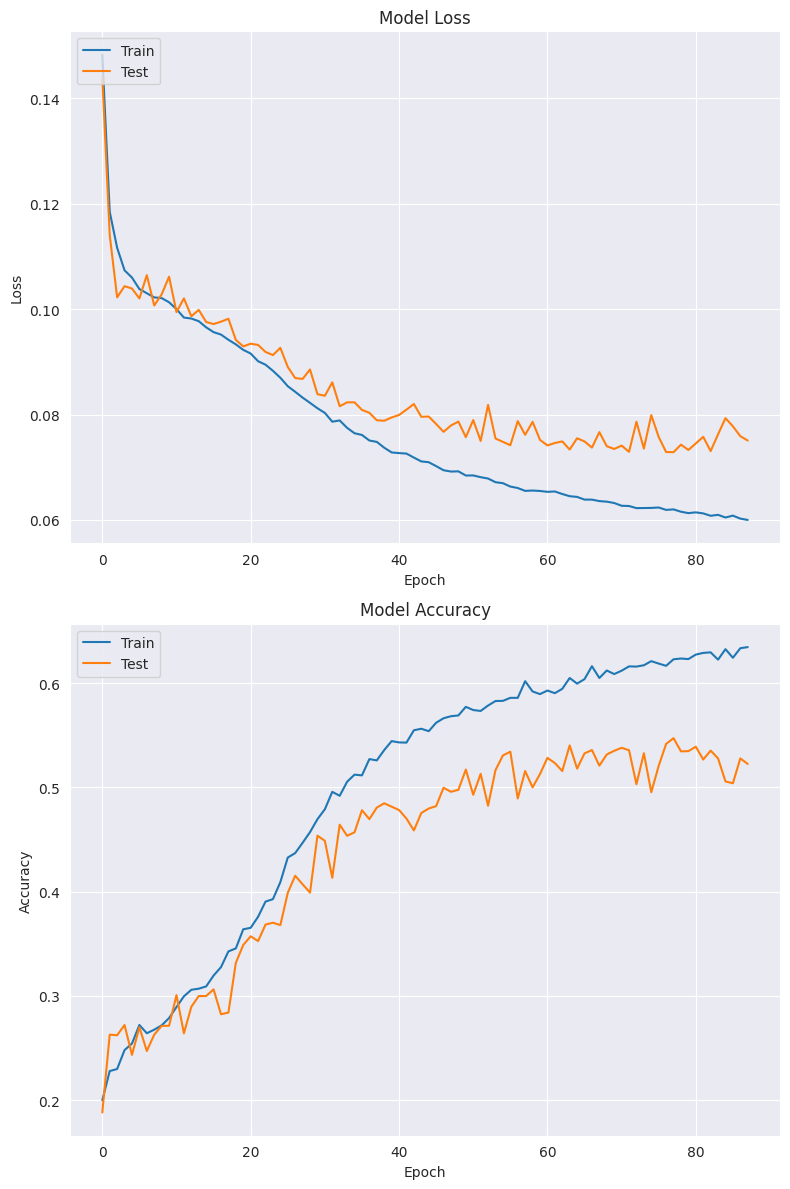

In [69]:
nn_model = neural_network(learning_rate, decay)
history_nn = train_loop(nn_model)
model_perf_plots(history_nn, 'accuracy', 'val_accuracy')

### Multi Layer Perceptron

In [70]:
def multilayer_perceptron(learning_rate, decay):
    # Create model
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=input_shape))
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='softmax'))

    # Compile model
    opt = Adam(lr=learning_rate, decay=decay)
    model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=[categorical_accuracy])

    model.summary()
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              35840     
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 1024)              263168    
                                                                 
 dense_8 (Dense)             (None, 2048)              2099200   
                                                                 
 dropout (Dropout)           (None, 2048)             

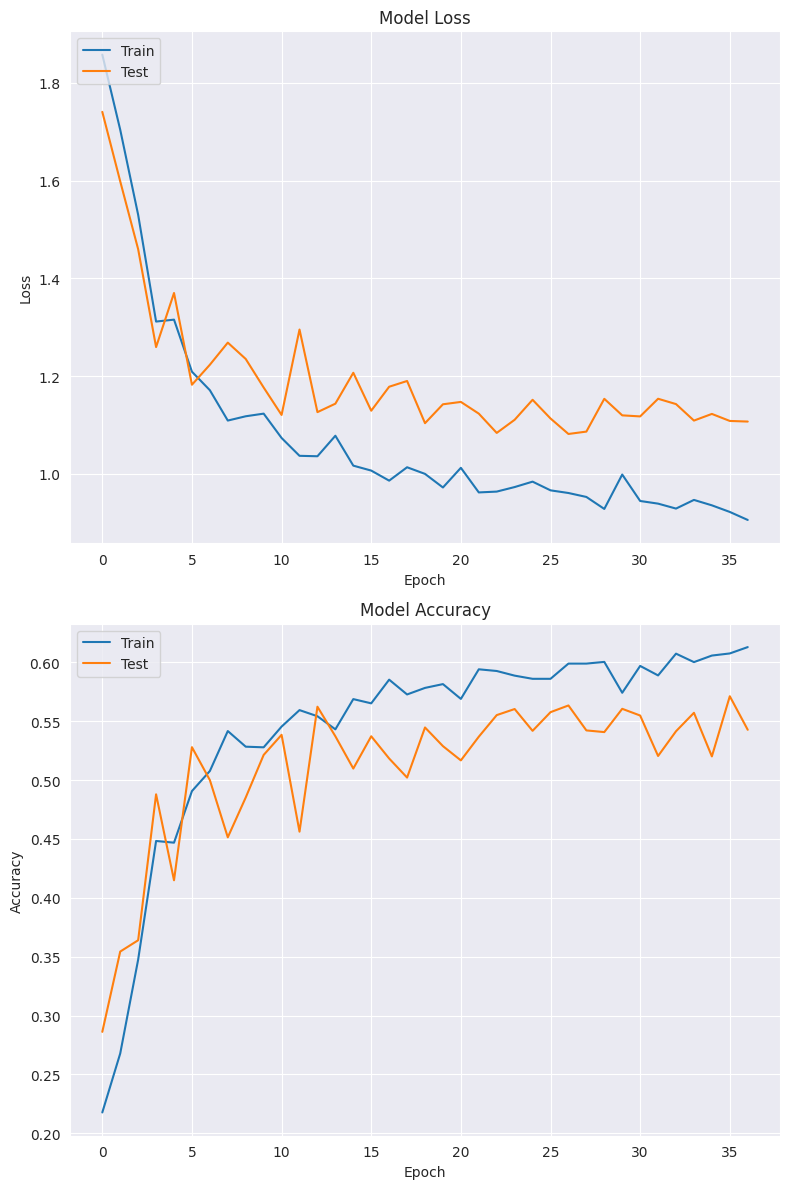

In [71]:
mlp_model = multilayer_perceptron(learning_rate, decay)
history_mlp = train_loop(mlp_model, early_stopping=True)
model_perf_plots(history_mlp, 'categorical_accuracy', 'val_categorical_accuracy')

### Observations

In [74]:
# create copies of original train, test data
lbl_train = labeled_train.copy(deep=True)
lbl_test = labeled_test.copy(deep=True)


In [75]:
lbl_train.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,880,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
1,881,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
2,882,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
3,883,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1
4,884,-0.00003,-0.00004,-0.00006,-0.00006,-0.00004,-0.00002,-0.00001,-0.00002,1,1


## Temporal Transformation

In [96]:
from keras.utils import to_categorical
data = np.array(lbl_train)
X = data[:, 1:9]
y = data[:, 9] - 1 # subtract 1 from each value in y
num_time_steps = 100
num_features = 8
num_samples = len(data) // num_time_steps
X = X[:num_samples * num_time_steps, :]
X = X.reshape(num_samples, num_time_steps, num_features)
y = y[:num_samples * num_time_steps]
y = y.reshape(num_samples, num_time_steps)

# This will create a new tensor y of shape (num_samples, num_time_steps, num_classes) 
# where each class label is represented as a binary vector of length 7.
y = to_categorical(y, num_classes=7)


print('Transformed X Shape: ', X.shape)
print('Transformed Y Shape: ', y.shape)


Transformed X Shape:  (7329, 100, 8)
Transformed Y Shape:  (7329, 100, 7)


In [97]:
X[:10,1,:]

array([[-3.e-05, -4.e-05, -6.e-05, -6.e-05, -4.e-05, -2.e-05, -1.e-05,
        -2.e-05],
       [-1.e-05, -1.e-05, -2.e-05, -1.e-05,  1.e-05, -1.e-05,  0.e+00,
         0.e+00],
       [ 4.e-05,  3.e-05,  1.e-05,  2.e-05,  0.e+00, -2.e-05, -1.e-05,
        -1.e-05],
       [-2.e-05, -2.e-05, -1.e-05, -1.e-05, -2.e-05,  0.e+00, -2.e-05,
        -2.e-05],
       [-1.e-05,  0.e+00,  3.e-05,  0.e+00, -1.e-05, -1.e-05, -3.e-05,
        -1.e-05],
       [ 4.e-05,  1.e-05,  2.e-05,  0.e+00,  0.e+00, -1.e-05, -2.e-05,
         0.e+00],
       [ 0.e+00,  1.e-05, -2.e-05, -2.e-05, -2.e-05,  0.e+00, -2.e-05,
         0.e+00],
       [ 0.e+00, -1.e-05,  1.e-05,  0.e+00,  0.e+00, -1.e-05, -2.e-05,
        -1.e-05],
       [-4.e-05, -2.e-05, -1.e-05,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        -3.e-05],
       [-2.e-05, -3.e-05, -4.e-05, -2.e-05, -1.e-05,  0.e+00, -3.e-05,
        -1.e-05]])

In [98]:
y[:10,1,:]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [99]:
print(num_features)

8


## Recurrent Neural Network (RNN)

In [100]:
from keras.layers import SimpleRNN

# Define the RNN model architecture
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(num_time_steps, num_features)))
model.add(Dense(units=7, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 32)                1312      
                                                                 
 dense_14 (Dense)            (None, 7)                 231       
                                                                 
Total params: 1,543
Trainable params: 1,543
Non-trainable params: 0
_________________________________________________________________


In [101]:
# Train the model
model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10


ValueError: ignored

## LSTM

### Basic LSTM

In [102]:
from keras.layers import LSTM
from keras.layers import Reshape

# Build the model
model = Sequential()
model.add(LSTM(128, input_shape=(num_time_steps, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))
model.add(Reshape((num_time_steps, 7)))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary)

# Train the model
model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
92/92 [==============================] - 41s 380ms/step - loss: 1.8522 - accuracy: 0.1607 - val_loss: 1.8691 - val_accuracy: 0.1679
Epoch 2/10
92/92 [==============================] - 39s 429ms/step - loss: 1.8300 - accuracy: 0.1668 - val_loss: 1.8633 - val_accuracy: 0.1675
Epoch 3/10
92/92 [==============================] - 36s 398ms/step - loss: 1.8288 - accuracy: 0.1653 - val_loss: 1.8650 - val_accuracy: 0.1673
Epoch 4/10
92/92 [==============================] - 38s 416ms/step - loss: 1.8262 - accuracy: 0.1619 - val_loss: 1.8676 - val_accuracy: 0.1683
Epoch 5/10
92/92 [==============================] - 34s 371ms/step - loss: 1.8241 - accuracy: 0.1640 - val_loss: 1.8709 - val_accuracy: 0.1538
Epoch 6/10
92/92 [==============================] - 37s 402ms/step - loss: 1.8242 - accuracy: 0.1632 - val_loss: 1.8661 - val_accuracy: 0.1683
Epoch 7/10
92/92 [==============================] - 34s 374ms/step - loss: 1.8230 - accuracy: 0.1640 - val_loss: 1.8703 - val_accuracy: 0.1520

In [103]:
# Test the model
test_data = np.array(lbl_test)
test_X = test_data[:, 1:9]
test_y = test_data[:, 9] - 1 # subtract 1 from each value in y
num_time_steps = 100
num_features = 8
num_samples = len(test_data) // num_time_steps
test_X = test_X[:num_samples * num_time_steps, :]
test_X = test_X.reshape(num_samples, num_time_steps, num_features)
test_y = test_y[:num_samples * num_time_steps]
test_y = test_y.reshape(num_samples, num_time_steps)
test_y = to_categorical(test_y, num_classes=7)

loss, accuracy = model.evaluate(test_X, test_y, batch_size=64)
print('Test Loss: ', loss)
print('Test Accuracy: ', accuracy)


116/116 [==============================] - 16s 135ms/step - loss: 1.8301 - accuracy: 0.1693
Test Loss:  1.8300597667694092
Test Accuracy:  0.16930870711803436


### Advanced LSTM

In [105]:
from keras.layers import LSTM
from keras.layers import Reshape, Flatten

# Build the model
model = Sequential()
model.add(LSTM(256, input_shape=(num_time_steps, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(num_time_steps * 7, activation='softmax'))
model.add(Reshape((num_time_steps, 7)))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Train the model
model.fit(X, y, epochs=50, batch_size=128, validation_split=0.2)

# Test the model
test_data = np.array(lbl_test)
test_X = test_data[:, 1:9]
test_y = test_data[:, 9] - 1 # subtract 1 from each value in y
num_time_steps = 100
num_features = 8
num_samples = len(test_data) // num_time_steps
test_X = test_X[:num_samples * num_time_steps, :]
test_X = test_X.reshape(num_samples, num_time_steps, num_features)
test_y = test_y[:num_samples * num_time_steps]
test_y = test_y.reshape(num_samples, num_time_steps)
test_y = to_categorical(test_y, num_classes=7)

loss, accuracy = model.evaluate(test_X, test_y, batch_size=128)
print('Test Loss: ', loss)
print('Test Accuracy: ', accuracy)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 100, 256)          271360    
                                                                 
 dropout_7 (Dropout)         (None, 100, 256)          0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 128)          197120    
                                                                 
 dropout_8 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)               